# Face Recognition using Siamese Network

### Install and Import Dependencies

In [ ]:
# Install dependencies
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [162]:
# Import dependencies
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [163]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, Input, Flatten, MaxPooling2D

### Set GPU Growth

In [164]:
# Avoid OOM (Out of Memory) errors by setting GPU Memory Consumption Growth
# GPU stands for Graphical Processing Unit
# gpus = tf.config.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [165]:
# Number of physical devices in the machine
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [166]:
# Number of CPU's in the machine
cpus = tf.config.list_physical_devices('CPU')
len(cpus)

1

In [167]:
# Printing the number of CPU's in the machine
for cpu in cpus:
    print(cpu)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [168]:
# Number of GPU's in the machine
len(gpus)

0

In [169]:
# Printing the GPU's in the machine
for gpu in gpus:
    print(gpu)

### Create Folder Structures

In [170]:
# POS_PATH for positive image path which has the correct images
POS_PATH = os.path.join('data', 'positive')

# NEG_PATH for negative image path which has incorrect images
NEG_PATH = os.path.join('data', 'negative')

# ANC_PATH for anchor image path which has the image to be tested against negative and positive images
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
# 'makedirs' makes the directory from scratch that is it creates all the intermediate directories
# Like in this example it will create 'data' directory under which 'positive' directory whould be made
# So the complete path using 'makedirs' will look like 'data\positive\'
# Whereas 'mkdir' creates single sub-directory that is,
# it would make just the 'positive' directory and not its super directory 'data'
# The complete path using 'mkdir' would look like 'positive\'
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [171]:
# Printing the path
print(POS_PATH)
print(NEG_PATH)
print(ANC_PATH)

data\positive
data\negative
data\anchor


### Collect Negatives from Labelled Faces in the Wild Dataset

In [ ]:
# Link to labelled faces in the wild dataset (Negative Input) : http://vis-www.cs.umass.edu/lfw/#download
# Uncompress Tar GZ labelled faces in the wild dataset
!tar -xf lfw.tgz

In [ ]:
# Move 'lfw' images to 'data\Negative'
# The first two lines of code generates the entire set of images from each files in each directory
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        
#         EX_PATH for existing path of the labelled images in the wild dataset
        EX_PATH = os.path.join('lfw', directory, file)
        
#         NEW_PATH for the path of 'Negative' directory in 'data' directory
        NEW_PATH = os.path.join(NEG_PATH, file)
        
#         Moving all labelled images into NEW_PATH
        os.replace(EX_PATH, NEW_PATH)

### Collect Positives and Anchors using Webcam

In [172]:
# Import uuid library to generate unique names to each image
# uuid stands for Univerally Unique IDentifier
import uuid

In [173]:
# Generation of unique filename via different forms
print('{}.jpg'.format(uuid.uuid1()))
print('{}.jpg'.format(uuid.uuid4()))

# Just to check how the unique filename is generated using 'uuid' along with the path
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

e5514d5e-390d-11ee-b6f8-f75f2ef10444.jpg
764f2606-174f-46ae-893c-a188a69c9880.jpg


'data\\anchor\\e55174a2-390d-11ee-9007-f75f2ef10444.jpg'

In [174]:
# Establish a connection to the Webcam
# Here, '0' is the device's webcam's location
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
#     Cut down frame to 250x250px
    frame = frame[170:170+250, 220:220+250, :]
    
#     Collect anchor images
#     On clicking 'a' on keyboard an anchor image would be created and stored in the desired directory
    if cv2.waitKey(1) & 0xFF == ord('a'):
#         Create the unique anchor image file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         Store the image in respective directory (Write out anchor image)
        cv2.imwrite(imgname, frame)
    
#     Collect positive images
#     On clicking 'p' on keyboard a positive image would be created and stored in the desired directory
    if cv2.waitKey(1) & 0xFF == ord('p'):
#         Create the unique positive image file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         Store the image in respective directory (Write out positive image)
        cv2.imwrite(imgname, frame)
    
#     Show Image back to screen
    cv2.imshow("Image Collection", frame)
    
#     Breaking gracefully
#     On clicking 'q' on keyboard, the looping would break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# Release the Webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

(250, 250, 3)


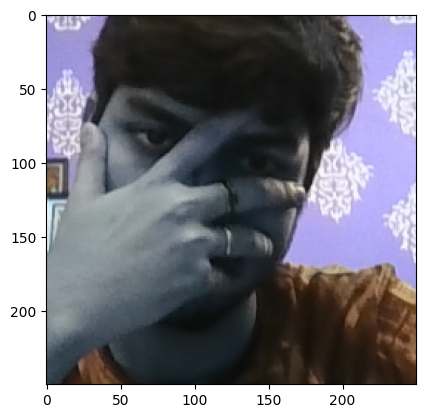

In [175]:
# Print the frame shape
print(frame.shape)
plt.imshow(frame)
plt.show()
# Image slicing
# print(frame[170:170+250, 220:220+250, :].shape)
# plt.imshow(frame[170:170+250, 220:220+250, :])
# plt.show()
# print(frame[250:250+250, 120:120+250, :].shape)
# plt.imshow(frame[250:250+250, 120:120+250, :])
# plt.show()

### Get Image Directories

In [176]:
# Getting the image file path from each directory
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [177]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\6c960b94-37ad-11ee-9597-346f24d0c492.jpg'


### Pre-Processing (Scale and Resize)

In [178]:
def preprocess(file_path):
    
#     Read the image from image file path
    byte_img = tf.io.read_file(file_path)
    
#     Load the image
    img = tf.io.decode_jpeg(byte_img)
    
#     Resize the image to 105x105x3
    img = tf.image.resize(img, (105, 105))
    
#     Scale the image to be between 0 and 1
    img = img / 255.0
    
#     Return the image
    return img

In [179]:
# Testing the above file path
img = preprocess('data\\anchor\\6c960b94-37ad-11ee-9597-346f24d0c492.jpg')

In [180]:
# Getting details of the image
img

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.965544  , 0.9733871 , 0.9537793 ],
        [0.96414566, 0.9728291 , 0.9529412 ],
        [0.95686275, 0.9764706 , 0.95116717],
        ...,
        [0.7001578 , 0.6743541 , 0.64243245],
        [0.66606635, 0.6309457 , 0.59573823],
        [0.68263525, 0.6454716 , 0.61017746]],

       [[0.96862745, 0.98039216, 0.9529412 ],
        [0.9678071 , 0.98013204, 0.95268106],
        [0.95714283, 0.9767507 , 0.9492997 ],
        ...,
        [0.6941777 , 0.64739895, 0.6142524 ],
        [0.7039416 , 0.64793915, 0.6131853 ],
        [0.71363217, 0.6576097 , 0.6220355 ]],

       [[0.96862745, 0.98039216, 0.9529412 ],
        [0.9661398 , 0.9784647 , 0.95101374],
        [0.95686275, 0.9764706 , 0.9490196 ],
        ...,
        [0.7260882 , 0.64883286, 0.6178338 ],
        [0.7395025 , 0.64824593, 0.6130452 ],
        [0.75115603, 0.6538638 , 0.62071717]],

       ...,

       [[0.82234854, 0.8123579 , 0.7516669 ],
        [0.74

In [181]:
# Printing the minimum and maximum pixel value in image
print(img.numpy().min())
print(img.numpy().max())

0.0
1.0


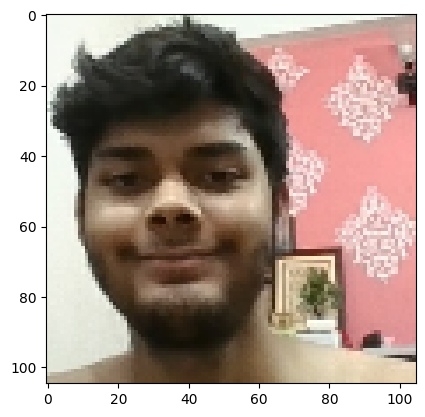

In [182]:
plt.imshow(img)

In [183]:
# dataset.map(preprocess)

### Create Labelled Dataset

In [184]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [185]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [186]:
tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

In [187]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
iterator_labels = class_labels.as_numpy_iterator()
iterator_labels.next()

1.0

In [188]:
# (anchor, positives) => 1, 1, 1, 1, 1
# (anchor, negatives) => 0, 0, 0, 0, 0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [189]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [190]:
data.as_numpy_iterator

<bound method DatasetV2.as_numpy_iterator of <ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>>

In [191]:
samples = data.as_numpy_iterator()
example = samples.next()

In [192]:
example

(b'data\\anchor\\7289631f-37ad-11ee-b1c7-346f24d0c492.jpg',
 b'data\\positive\\80aa1e0a-37ad-11ee-98cc-346f24d0c492.jpg',
 1.0)

### Build Train and Test Partition

In [193]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

tf.Tensor(
[[[0.96199816 0.97376287 0.94631183]
  [0.9647059  0.9764706  0.9490196 ]
  [0.9664799  0.9782446  0.9507936 ]
  ...
  [0.71582186 0.68650347 0.6577119 ]
  [0.6626183  0.6297518  0.6007002 ]
  [0.66862524 0.63575876 0.59925085]]

 [[0.9610644  0.9728291  0.9453781 ]
  [0.9647059  0.9764706  0.9490196 ]
  [0.9664799  0.9782446  0.9507936 ]
  ...
  [0.6894424  0.635194   0.5996198 ]
  [0.69953984 0.64351743 0.6079432 ]
  [0.71671337 0.64920634 0.6151261 ]]

 [[0.9647059  0.9764706  0.9490196 ]
  [0.9647059  0.9764706  0.9490196 ]
  [0.9647059  0.9764706  0.9490196 ]
  ...
  [0.73708594 0.6496354  0.6129407 ]
  [0.7429772  0.6482126  0.60494864]
  [0.7488329  0.64939314 0.6084033 ]]

 ...

 [[0.87832695 0.8872905  0.83536536]
  [0.87267584 0.8836602  0.82888496]
  [0.8880841  0.89377975 0.8345827 ]
  ...
  [0.8652106  0.7995155  0.6932596 ]
  [0.8524076  0.787515   0.6812591 ]
  [0.8751523  0.81025964 0.7040038 ]]

 [[0.84245676 0.8390954  0.7690674 ]
  [0.73177236 0.7278308  0

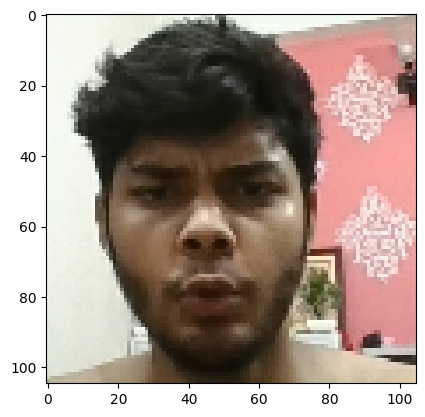

In [194]:
res = preprocess_twin(*example)
print(res[0])
plt.imshow(res[0])

tf.Tensor(
[[[0.9533169  0.97292477 0.9454738 ]
  [0.9529412  0.9728291  0.9445378 ]
  [0.95349026 0.97701967 0.937804  ]
  ...
  [0.7203592  0.70132273 0.6591192 ]
  [0.67178196 0.64797246 0.60754293]
  [0.65751415 0.6246476  0.58813965]]

 [[0.9535014  0.972549   0.94509804]
  [0.957443   0.97649056 0.9490396 ]
  [0.9575764  0.9782713  0.9456249 ]
  ...
  [0.69642526 0.6496465  0.61229825]
  [0.69997996 0.6442377  0.60866344]
  [0.71064425 0.6540617  0.61876756]]

 [[0.9647059  0.9764706  0.9490196 ]
  [0.96485925 0.97662395 0.949173  ]
  [0.96685344 0.97861814 0.9476191 ]
  ...
  [0.7264617  0.6480303  0.6082166 ]
  [0.7284114  0.6371549  0.6013939 ]
  [0.74641633 0.64549375 0.61140233]]

 ...

 [[0.863003   0.8800898  0.84302163]
  [0.8728358  0.88954246 0.8487462 ]
  [0.88100797 0.8927727  0.8496354 ]
  ...
  [0.8226913  0.76509935 0.6776487 ]
  [0.8094837  0.7559823  0.6675602 ]
  [0.8182072  0.7629317  0.68412685]]

 [[0.87871146 0.89047617 0.85518205]
  [0.87084836 0.88261306 0

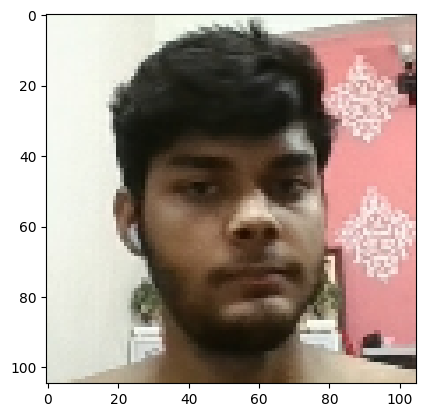

In [195]:
print(res[1])
plt.imshow(res[1])

In [196]:
print(res[2])

1.0


### Build Data Loader Pipeline

In [197]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [198]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

3


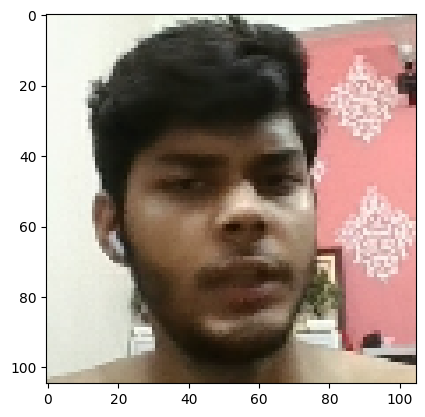

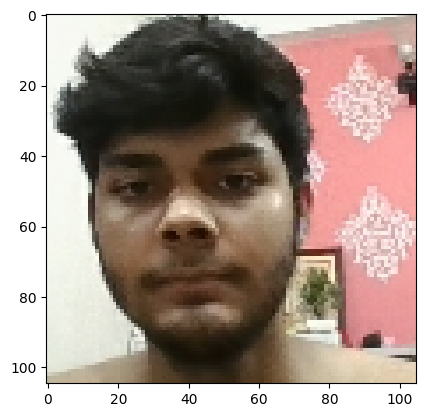

Label :  1.0


(array([[[0.96862745, 0.9764706 , 0.95686275],
         [0.9660264 , 0.97779113, 0.9503401 ],
         [0.9659308 , 0.9776955 , 0.9466965 ],
         ...,
         [0.744291  , 0.7184873 , 0.68411577],
         [0.709197  , 0.6767173 , 0.6474723 ],
         [0.67357606, 0.63828194, 0.6029878 ]],
 
        [[0.96498597, 0.9767507 , 0.9492997 ],
         [0.9686075 , 0.9803722 , 0.95288116],
         [0.9683474 , 0.9801121 , 0.9488062 ],
         ...,
         [0.7085301 , 0.662465  , 0.6212886 ],
         [0.7111244 , 0.6593437 , 0.62292916],
         [0.71335196, 0.6573296 , 0.6193277 ]],
 
        [[0.96862745, 0.98039216, 0.9529412 ],
         [0.96635324, 0.97811794, 0.94681203],
         [0.9647059 , 0.9764706 , 0.9411765 ],
         ...,
         [0.7324752 , 0.65914136, 0.6085345 ],
         [0.74232364, 0.6573563 , 0.61216486],
         [0.73613447, 0.6409897 , 0.59785247]],
 
        ...,
 
        [[0.880859  , 0.8904873 , 0.83613443],
         [0.8879751 , 0.89367074, 0.83447

In [199]:
samples = data.as_numpy_iterator()
print(len(samples.next()))
plt.imshow(samples.next()[0])
plt.show()
plt.imshow(samples.next()[1])
plt.show()
print("Label : ", samples.next()[2])
samples.next()

### Training Partition

In [200]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [201]:
print(round(len(data)*.7))
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(20)
train_data = train_data.prefetch(10)

420


In [202]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [203]:
train_samples = train_data.as_numpy_iterator()
print(len(train_samples.next()[0]))

20


### Testing Partiton

In [204]:
print(round(len(data)*.3))
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(20)
test_data = test_data.prefetch(10)

180


In [205]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

20


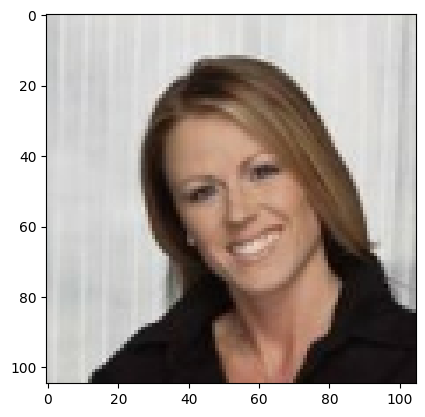

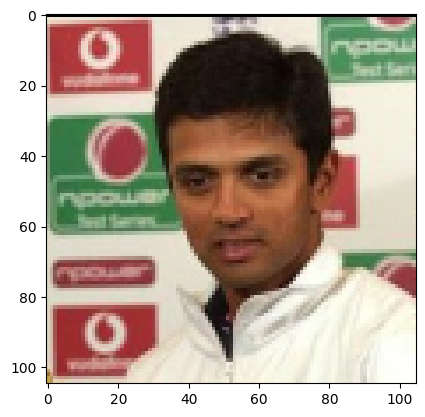

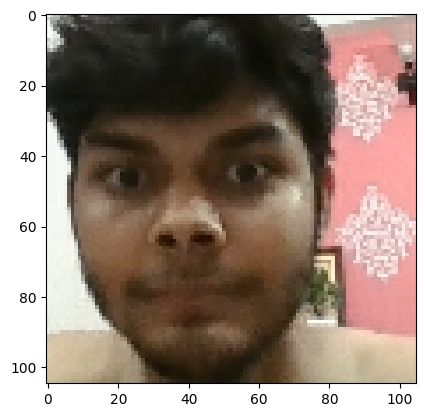

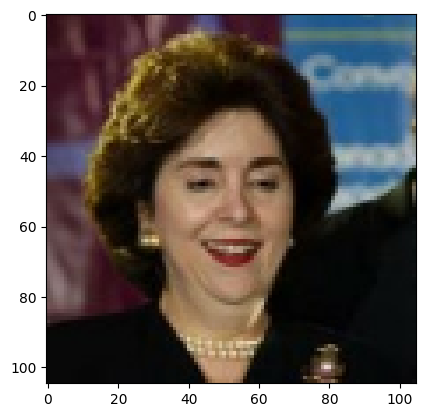

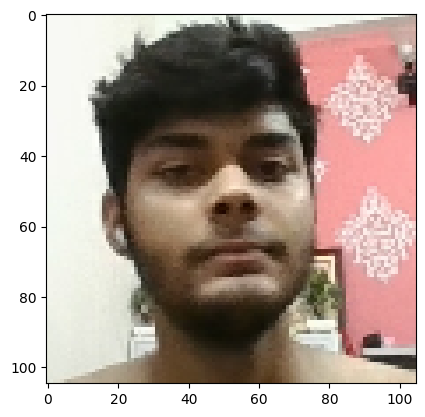

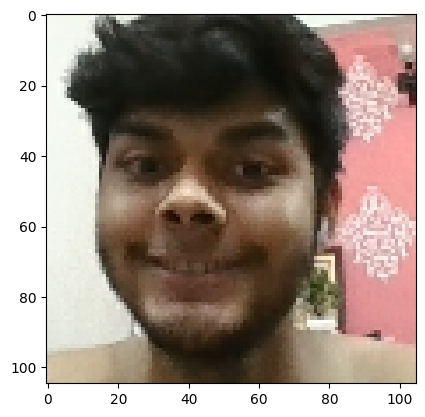

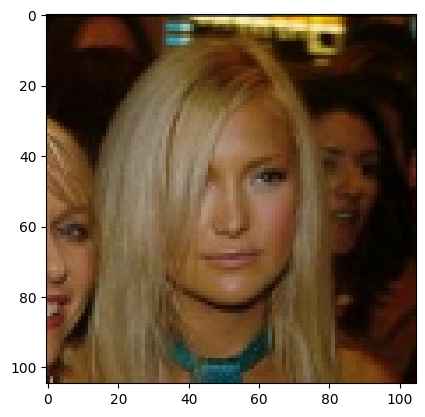

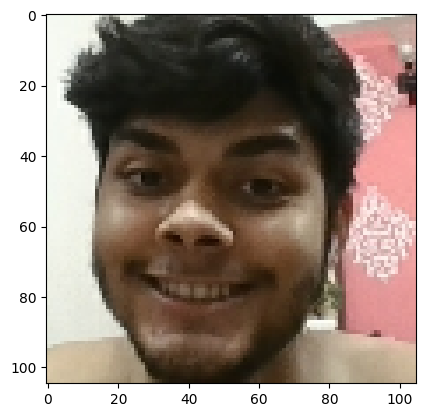

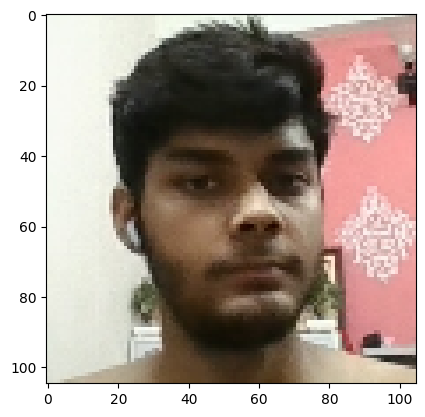

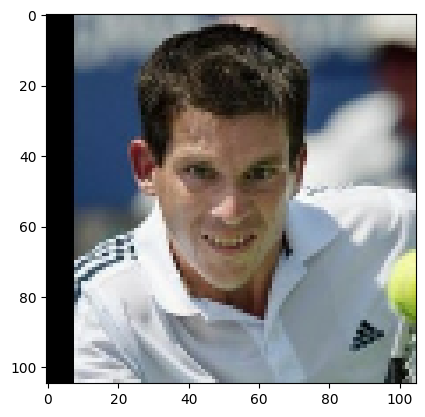

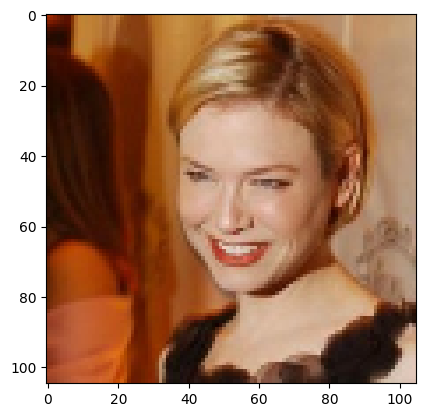

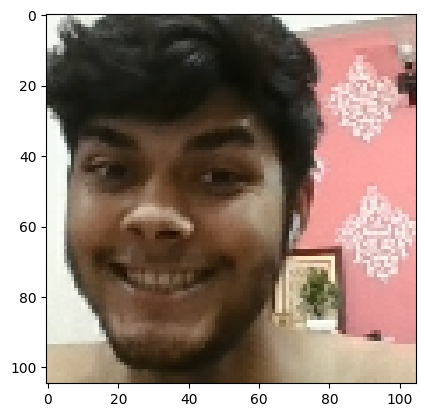

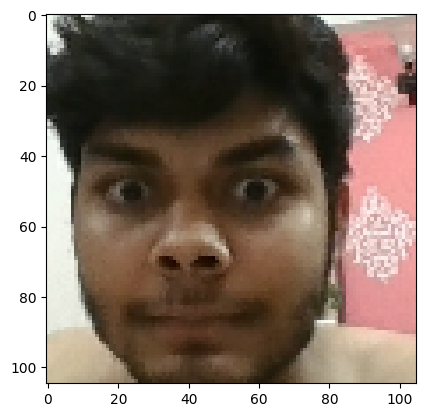

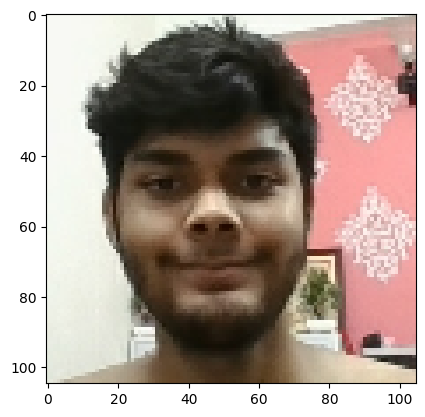

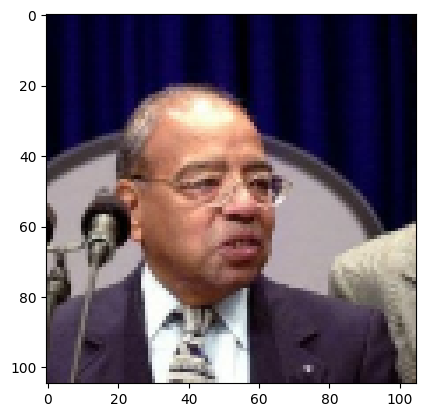

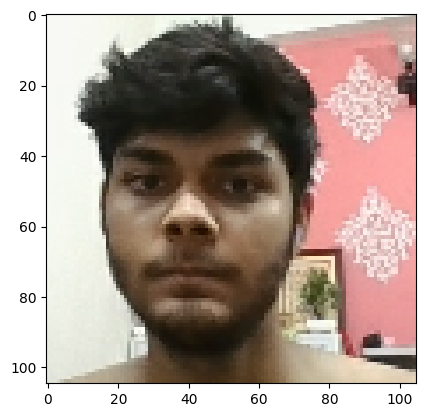

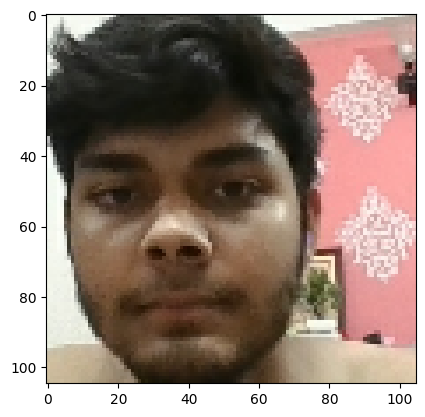

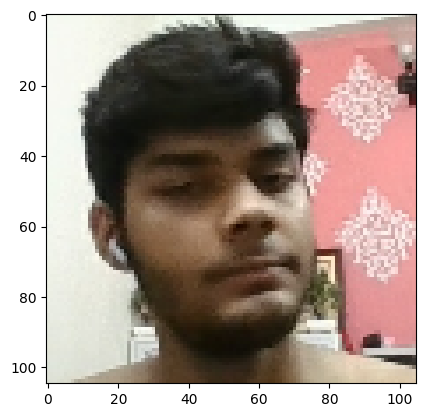

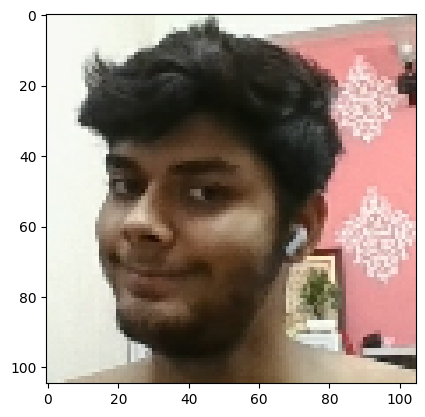

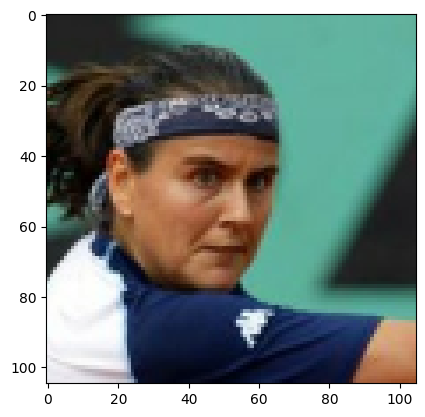

In [206]:
test_samples = test_data.as_numpy_iterator()
print(len(test_samples.next()[0]))
for img in test_samples.next()[1]:
    plt.imshow(img)
    plt.show()

### Build Embedding Layer

In [207]:
inp = Input(shape=(105, 105, 3), name='input_image')

In [208]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [209]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name='input_image')
    
#     First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    mp1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
#     Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(mp1)
    mp2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
#     Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(mp2)
    mp3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
#     Final Embedding Block
    c4 = Conv2D(256, (4, 4), activation='relu')(mp3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [210]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 18, 18, 128)       26

### Build Distance Layer

In [211]:
# Siamese L1 distance class
class L1dist(Layer):
    
#     Init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
#     Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [212]:
l1 = L1dist()

In [213]:
# l1(anchor_embedding, validation_embedding)

In [214]:
l1

### Make Siamese Model

In [215]:
def make_siamese_model():
    
#     Anchor image in the network
    input_image = Input(name='input_img', shape=(105, 105, 3))
    
#     Validation image in the network
    validation_image = Input(name='validation_img', shape=(105, 105, 3))
    
#     Combine siamese distance components
    siamese_layer = L1dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
#     Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [216]:
Siamese_Model = make_siamese_model()
Siamese_Model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

### Setup Loss and Optimizer

In [217]:
# Binary loss function
binary_loss = tf.losses.BinaryCrossentropy()

# Adam optimizer with 0.0001 learning rate
optimizer = tf.keras.optimizers.Adam(1e-4)

### Establish Checkpoints

In [130]:
# Make training_checkpoints directory in the main directory
CHECKPOINT_PATH = os.path.join('training_checkpoints')
os.makedirs(CHECKPOINT_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'training_checkpoints'

In [218]:
checkpoint_dir = './training_checkpoints/'

# Store the checkpoints as 'ckpt' file in training_checkpoints directory
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# What the checkpoint should store in it?
checkpoint = tf.train.Checkpoint(optimizer=optimizer, Siamese_Model=Siamese_Model)

### Build Train Step Function

In [219]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
x = batch_1[:2]
y = batch_1[2]
x, y

((array([[[[0.96862745, 0.98039216, 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           ...,
           [0.7084677 , 0.68101674, 0.64180106],
           [0.66964114, 0.6345204 , 0.5991396 ],
           [0.67059046, 0.63342667, 0.6005602 ]],
  
          [[0.96862745, 0.98039216, 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           ...,
           [0.69579834, 0.6497332 , 0.61210483],
           [0.7028411 , 0.64767903, 0.6112645 ],
           [0.7130719 , 0.6574163 , 0.6193277 ]],
  
          [[0.96862745, 0.98039216, 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           [0.96943   , 0.9795896 , 0.9529412 ],
           ...,
           [0.714697  , 0.6415322 , 0.59819037],
           [0.729225  , 0.64780575, 0.6012205 ],
           [0.7449113 , 0.6593837 , 0.61447245]],
  
          ...,
  
          [[0.8849073 , 0.8899382 , 0.83

In [220]:
@tf.function
def train_steps(batch):
    
#     Record all operations
    with tf.GradientTape() as tape:
#         Get anchor and positive/negative images
        X = batch[:2]
#         Get label
        Y = batch[2]
        
#         Forward pass
        Y_pred = Siamese_Model(X, training=True)
#         Calculate loss
        loss = binary_loss(Y, Y_pred)
        
    print(loss)
    
#     Calculate gradients
    grad = tape.gradient(loss, Siamese_Model.trainable_variables)
    
#     Calculate updated weights and apply it to siamese model
    optimizer.apply_gradients(zip(grad, Siamese_Model.trainable_variables))
    
    return loss

### Build Training Loop

In [221]:
def train(data, EPOCHS):
    
#     Loop through eeach epoch
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progress_bar = tf.keras.utils.Progbar(len(data))
        
#         Loop through each batch
        for index, batch in enumerate(data):
#             Run train step here
            train_steps(batch)
            progress_bar.update(index+1)
            
#         Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the Model

In [222]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


KeyboardInterrupt: 

### Import Metrics

In [224]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [248]:
# Get a batch of test data
test_input_img, test_val_img, actual_label = test_data.as_numpy_iterator().next()

In [249]:
# Make Predictions
predictions = Siamese_Model.predict([test_input_img, test_val_img])
predictions

1/1 [==============================] - 2s 2s/step


array([[0.481932  ],
       [0.48511028],
       [0.4908322 ],
       [0.5001843 ],
       [0.49958742],
       [0.49796113],
       [0.4976578 ],
       [0.5002429 ],
       [0.48504174],
       [0.4949629 ],
       [0.48654094],
       [0.4990774 ],
       [0.49253467],
       [0.49068013],
       [0.49910083],
       [0.5002016 ],
       [0.49413407],
       [0.49835923],
       [0.4992997 ],
       [0.49926442]], dtype=float32)

In [250]:
# Post processing the predictions
[1 if predict > 0.5 else 0 for predict in predictions]
# res = []
# for predict in predictions:
#     if predict > 0.5:
#         res.append(1)
#     else:
#         res.append(0)

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [251]:
# Cross-checking with the actual label
actual_label

array([0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 0.], dtype=float32)

### Calculate Metrics

In [255]:
# Creating recall metric object
r = Recall()

# Calculating recall value
r.update_state(actual_label, predictions)

# Return recall result
r.result().numpy()

0.375

In [256]:
# Creating precision metric object
p = Precision()

# Calculating precision value
p.update_state(actual_label, predictions)

# Return precision result
p.result().numpy()

1.0

### Visualize Results

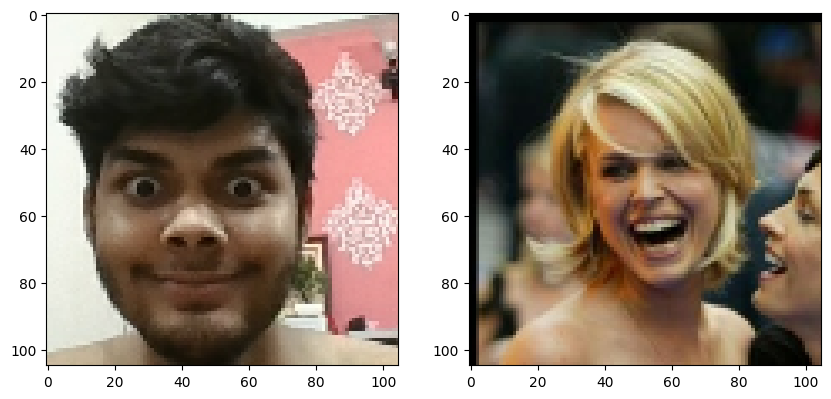

In [259]:
# Set plot size
plt.figure(figsize=(10, 8))

# Set first subplot (no. of rows, no. of columns, index of the image)
plt.subplot(1, 2, 1)
plt.imshow(test_input_img[10])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val_img[10])

# Renders cleanly
plt.show()

### Save Model

In [261]:
# Save weights
Siamese_Model.save('siamese_model.h5')

In [263]:
# Reload model
model = tf.keras.models.load_model('siamese_model.h5',
                                  custom_objects={'L1dist':L1dist, 'Binary_Crossentropy':tf.losses.BinaryCrossentropy()})

In [265]:
# make predictions with reloaded model
model.predict([test_input_img, test_val_img])

1/1 [==============================] - 2s 2s/step


array([[0.481932  ],
       [0.48511028],
       [0.4908322 ],
       [0.5001843 ],
       [0.49958742],
       [0.49796113],
       [0.4976578 ],
       [0.5002429 ],
       [0.48504174],
       [0.4949629 ],
       [0.48654094],
       [0.4990774 ],
       [0.49253467],
       [0.49068013],
       [0.49910083],
       [0.5002016 ],
       [0.49413407],
       [0.49835923],
       [0.4992997 ],
       [0.49926442]], dtype=float32)

In [ ]:
# View model summary
model.summary()